# ¿Como trabajar con el archivo en línea?

En este tutorial vamos a continuar trabajando con una de las librerías con las que hicimos la descarga de datos,
pero esta vez para hacer una figura, sin necesidad de hacer la descarga del dato.
Esta puede ser una opción viable en caso no tener espacio o solo revisar una fecha.

Además de la librería para conectar con AWS, vamos a necesitar para este tutorial tener instalado las siguientes librerías:</br>

**netCDF4** : https://pypi.org/project/netCDF4/</br>
**numpy** : https://pypi.org/project/numpy/</br>
**matplotlib** : https://pypi.org/project/matplotlib/</br>
**cartopy** : https://pypi.org/project/Cartopy/</br>
**xarray** : https://pypi.org/project/xarray/</br>

Recordar la estructura de datos de la base en el siguiente [link](https://fmcarrasco.github.io/documentation_crc_sas/SISSA_database/2Estructura_de_datos/)

In [1]:
# Comenzamos importando las librerías necesarias:
%matplotlib inline

import s3fs
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Colocamos los DATOS necesarios para trabajar con un archivo
# En este caso, decidimos trabajar con la temperatura media
# del miercoles 31 de marzo de 2010 (pronostico corregido)

BUCKET_NAME = 'sissa-forecast-database'
tforecast = 'subseasonal'
modelo = 'GEFSv12_corr'
variable = 'tmean'
year = '2010'
ymd = '20100331'
nens = 'p03'
narchivo = variable + '_' + ymd + '_' + nens + '.nc'
PATH = tforecast + '/' + modelo + '/' + variable + '/' + year + '/' + ymd + '/'

print(PATH + narchivo)

subseasonal/GEFSv12_corr/tmean/2010/20100331/tmean_20100331_p03.nc


In [2]:
# Cargamos los paises y estados/provincias
# Esto para el mapa final que se va a construir
countries = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='10m',
        facecolor='none')
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')


In [3]:
# Comenzamos la conexion de forma anonima, dado que no es necesario tener cuenta en AWS:

fs = s3fs.S3FileSystem(anon=True)
awsfile = 's3://' + BUCKET_NAME + '/' + PATH + narchivo
print('Trabajamos con el archivo:')
print(awsfile)

Trabajamos con el archivo:
s3://sissa-forecast-database/subseasonal/GEFSv12_corr/tmean/2010/20100331/tmean_20100331_p03.nc


20100331
20100406


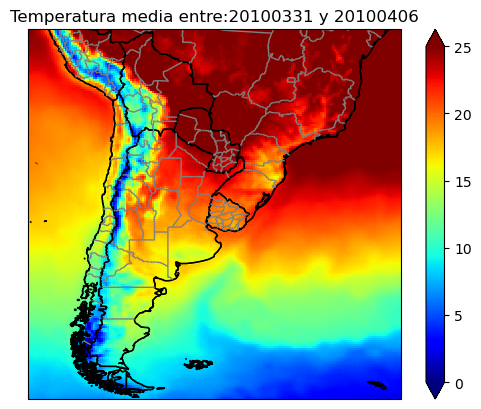

In [4]:
# Cargamos el dato a una variable en python
# Aca usamos el paquete netCDF4
with fs.open(awsfile) as f:  # Abrimos el archivo en línea
    with netCDF4.Dataset(f, memory=f.read()) as gefs: # Lo cargamos a una variable con la librería netcdf4
        # cargamos los datos a variables numpy (variable = 'tmean')
        var = gefs[variable][:]
        lat = gefs['lat'][:]
        lon = gefs['lon'][:]
        ntime = gefs['time']
        fechas = netCDF4.num2date(ntime[:], units=ntime.units, calendar=ntime.calendar, 
                                  only_use_cftime_datetimes=False, only_use_python_datetimes=True)
        print(fechas[0].strftime('%Y%m%d'))
        print(fechas[6].strftime('%Y%m%d'))
        # Calculamos la media de la primera semana
        mean = np.mean(var[0:7,:,:], axis=0)
        # Comenzamos la figura
        fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()})
        # Hacemos la figura
        cs = ax.pcolormesh(lon, lat, mean, transform=ccrs.PlateCarree(), vmin=0, vmax=25, cmap='jet')
        # Agregamos detalles de la costa, paises y estados
        ax.coastlines()
        ax.add_feature(countries, edgecolor='black')
        ax.add_feature(states_provinces, edgecolor='gray')
        # Agregamos una barra de colores y titulo
        cbar = fig.colorbar(cs, extend='both')
        titulo = 'Temperatura media entre:' + fechas[0].strftime('%Y%m%d') + ' y ' + fechas[6].strftime('%Y%m%d')
        ax.set_title(titulo)

        # Guarda la figura con una resolucion de 100 dpi y ajusta para que no queden bordes blancos
        plt.savefig('test_promedio.jpg', dpi=100, bbox_inches='tight')

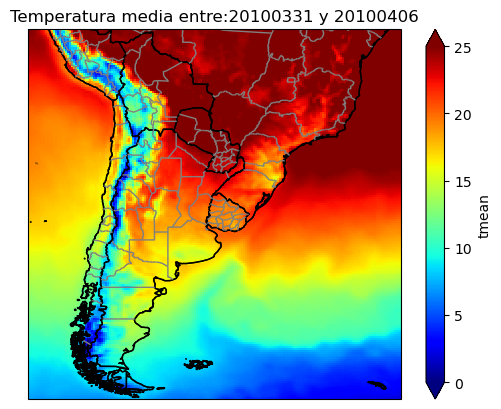

In [5]:
# Cargamos el dato a una variable en python
# Aca usamos el paquete xarray
import xarray as xr

with fs.open(awsfile) as f:  # Abrimos el archivo en línea
    with xr.open_dataset(f) as gefs: # Lo cargamos a una variable con la librería netcdf4
        # Calculamos la media de la primera semana
        mean = gefs[variable].sel(time=slice(ymd,'20100406')).mean(dim='time')
        # Comenzamos la figura
        fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()})
        # Hacemos la figura
        mean.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=25, cmap='jet')
        # Agregamos detalles de la costa, paises y estados
        ax.coastlines()
        ax.add_feature(countries, edgecolor='black')
        ax.add_feature(states_provinces, edgecolor='gray')
        # Agregamos una barra de colores y titulo
        cbar = fig.colorbar(cs, extend='both')
        titulo = 'Temperatura media entre:' + fechas[0].strftime('%Y%m%d') + ' y ' + fechas[6].strftime('%Y%m%d')
        ax.set_title(titulo)

        # Guarda la figura con una resolucion de 100 dpi y ajusta para que no queden bordes blancos
        plt.savefig('test_promedio_xarray.jpg', dpi=100, bbox_inches='tight')